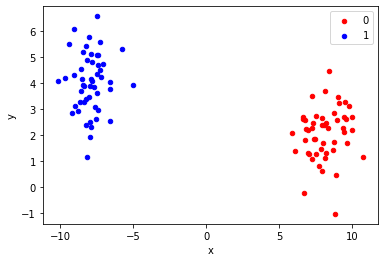

In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

dev_wires = [np.array(0, requires_grad=True), np.array(1, requires_grad=True), np.array(2, requires_grad=True), np.array(3, requires_grad=True)]#, np.array(4, requires_grad=False)]
dev = qml.device('default.qubit', wires=dev_wires)
#dev = qml.device("default.qubit", wires=4)

from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
features, labels = make_blobs(n_samples=100, centers=2, n_features=2)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=features[:,0], y=features[:,1], label=labels))

colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [2]:
def loss_l1(y_pred, y_true):
    return tf.abs(y_pred - y_true)

def loss_l2(y_pred, y_true):
    return (y_pred - y_true)**2

In [4]:
def apply_embedding(features, embedding_type = 'amplitude'):
    num_wires = 4 #len(features)
    wires = list(range(num_wires))
    
    if embedding_type is None or embedding_type == 'amplitude':
        qml.AmplitudeEmbedding(features,wires)
        
    if embedding_type == 'hub20': #https://arxiv.org/pdf/2003.09887v2.pdf
        for wire_idx in range(num_wires):
            qml.RX(features[wire_idx % 2], wires=dev_wires[wire_idx])
            
        for wire_idx in range(num_wires):
            qml.RY(np.pi/4, wires=dev_wires[wire_idx])
            
        for wire_idx in range(num_wires):
            qml.RZ(np.pi/4, wires=dev_wires[wire_idx])

@qml.qnode(dev)
def variational_circuit1(params):#, y_true, loss):#, features, embedding_type = 'amplitude'):
    
    for i in range(4):
        qml.RX(params[0], wires=dev_wires[i])
        
    for i in range(4):
        qml.RZ(params[1], wires=dev_wires[i])
    
    #return tf.abs(qml.expval(qml.PauliZ(dev_wires[0])), y_true)#, qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))
    return qml.expval(qml.PauliZ(dev_wires[0]))
"""
@qml.qnode(dev_circuit1)
def variational_circuit2(param):
    for i in range(4):
        qml.RX(param, wires=i)
        
    for i in range(4):
        qml.RZ(param, wires=i)
        
    for i in [2,1,0]:
        qml.CNOT(wires=[i+1, i])

    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))

@qml.qnode(dev_circuit1)
def variational_circuit3(param):
    for i in range(4):
        qml.RX(param, wires=i)
        
    for i in range(4):
        qml.RZ(param, wires=i)
        
    for i in [2,1,0]:
        qml.CRZ(param, wires=[i+1, i])

    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))

@qml.qnode(dev_circuit1)
def variational_circuit4(param):
    for i in range(4):
        qml.RX(param, wires=i)
        
    for i in range(4):
        qml.RZ(param, wires=i)
    
    for i in [2,1,0]:
        qml.CRX(param, wires=[i+1, i])

    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))
"""

'\n@qml.qnode(dev_circuit1)\ndef variational_circuit2(param):\n    for i in range(4):\n        qml.RX(param, wires=i)\n        \n    for i in range(4):\n        qml.RZ(param, wires=i)\n        \n    for i in [2,1,0]:\n        qml.CNOT(wires=[i+1, i])\n\n    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))\n\n@qml.qnode(dev_circuit1)\ndef variational_circuit3(param):\n    for i in range(4):\n        qml.RX(param, wires=i)\n        \n    for i in range(4):\n        qml.RZ(param, wires=i)\n        \n    for i in [2,1,0]:\n        qml.CRZ(param, wires=[i+1, i])\n\n    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))\n\n@qml.qnode(dev_circuit1)\ndef variational_circuit4(param):\n    for i in range(4):\n        qml.RX(param, wires=i)\n        \n    for i in range(4):\n        qml.RZ(param, wires=i)\n    \n    for i in [2,1,0]:\n        qml.CRX(param, wires=[i+1, i

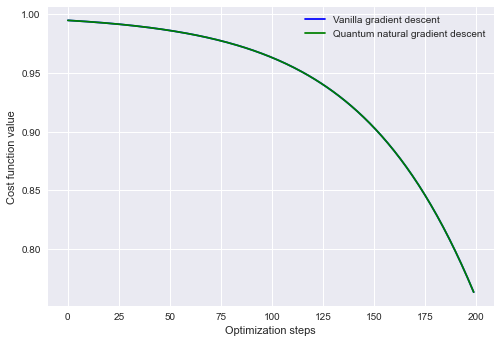

In [5]:
steps = 200

init_params = np.array([0.1, 0.1])

input_features = features[0]
y_true = features[0]

gd_cost = []
theta = init_params
opt = qml.GradientDescentOptimizer(0.01)
for _ in range(steps):
    #print(theta)
    theta = opt.step(variational_circuit1, theta)#, y_true, loss_l1)
    #print(theta)
    gd_cost.append(variational_circuit1(theta))#, y_true, loss_l1))

#Performing quantum natural gradient descent:

qng_cost = []
opt = qml.QNGOptimizer(0.01)

theta = init_params
for _ in range(steps):
    theta = opt.step(variational_circuit1, theta)#, y_true, loss_l1)
    qng_cost.append(variational_circuit1(theta))#, y_true, loss_l1))

#Plotting the cost vs optimization step for both optimization strategies:

from matplotlib import pyplot as plt

plt.style.use("seaborn")
plt.plot(gd_cost, "b", label="Vanilla gradient descent")
plt.plot(qng_cost, "g", label="Quantum natural gradient descent")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()


#circuit = variational_circuit1(init_params, features[0], 'hub20')

#drawer = qml.draw(variational_circuit1, wire_order=[0, 1, 2, 3])

#print(type(variational_circuit1))

#print(drawer(init_params, features[10], 'hub20'))

In [ ]:
#https://pennylane.readthedocs.io/en/user-docs-refactor/tutorials/pennylane_run_quantum_natural_gradient.html#quantum-natural-gradient

In [ ]:
g0 = np.zeros([4, 4])
input_features = features[0]

def layer0_subcircuit(params):
    """This function contains all gates that
    precede parametrized layer 0"""
    apply_embedding(input_features, 'hub20')

In [ ]:
params = np.array([0.432, -0.123, 0.543, 0.233])
w0 = np.array(0, requires_grad=True)
w1 = np.array(1, requires_grad=True)
w2 = np.array(2, requires_grad=True)
w3 = np.array(3, requires_grad=True)

@qml.qnode(dev)
def layer0_diag(params):
    layer0_subcircuit(params)
    return qml.var(qml.PauliX(w0)), qml.var(qml.PauliX(w1)), qml.var(qml.PauliX(w2)), qml.var(qml.PauliX(w3))

# calculate the diagonal terms
varK0, varK1, varK2, varK3 = layer0_diag(params)
g0[0, 0] = varK0/4
g0[1, 1] = varK1/4
g0[2, 2] = varK2/4
g0[3, 3] = varK3/4

@qml.qnode(dev)
def layer0_off_diag_single(params):
    layer0_subcircuit(params)
    return [qml.expval(qml.PauliX(w0)), qml.expval(qml.PauliX(w1)),
            qml.expval(qml.PauliX(w2)), qml.expval(qml.PauliX(w3))]

@qml.qnode(dev)
def layer0_off_diag_double(params, wire1, wire2):
    layer0_subcircuit(params)
    X = np.matrix([[0, 1], [1, 0]])
    XX = np.kron(X, X)
    return qml.expval(qml.Hermitian(XX, wires=[wire1, wire2]))

# calculate the off-diagonal terms
exK_list = layer0_off_diag_single(params)

for i in range(4):
    for j in range(4):
        if i != j:
            exKiKj = layer0_off_diag_double(params, i, j)
            g0[i, j] = (exKiKj - exK_list[i]*exK_list[j])/4
            g0[j, i] = (exKiKj - exK_list[i]*exK_list[j])/4

In [ ]:
g1 = np.zeros([4, 4])

def layer1_subcircuit(params):
    """This function contains all gates that
    precede parametrized layer 1"""
    # |psi_0>: state preparation
    apply_embedding(input_features, 'hub20')

    # V0(theta0, theta1): Parametrized layer 0
    for i in range(4):
        qml.RX(params[i], wires=dev_wires[i])

    # W1: non-parametrized gates
    for i in range(3):
        qml.CNOT(wires=[dev_wires[i], dev_wires[i+1]])
        
@qml.qnode(dev)
def layer1_diag(params):
    layer1_subcircuit(params)
    return qml.var(qml.PauliZ(w0)), qml.var(qml.PauliZ(w1)), qml.var(qml.PauliZ(w2)), qml.var(qml.PauliZ(w3))

# calculate the diagonal terms
varK0, varK1, varK2, varK3 = layer1_diag(params)
g1[0, 0] = varK0/4
g1[1, 1] = varK1/4
g1[2, 2] = varK2/4
g1[3, 3] = varK3/4

@qml.qnode(dev)
def layer1_off_diag_single(params):
    layer1_subcircuit(params)
    return [qml.expval(qml.PauliZ(w0)), qml.expval(qml.PauliZ(w1)),
            qml.expval(qml.PauliZ(w2)), qml.expval(qml.PauliZ(w3))]

@qml.qnode(dev)
def layer1_off_diag_double(params, wire1, wire2):
    layer1_subcircuit(params)
    Z = np.matrix([[1, 0], [0, -1]])
    ZZ = np.kron(Z, Z)
    return qml.expval(qml.Hermitian(ZZ, wires=[wire1, wire2]))

# calculate the off-diagonal terms
exK_list = layer1_off_diag_single(params)

for i in range(4):
    for j in range(4):
        if i != j:
            exKiKj = layer0_off_diag_double(params, i, j)
            g1[i, j] = (exKiKj - exK_list[i]*exK_list[j])/4
            g1[j, i] = (exKiKj - exK_list[i]*exK_list[j])/4

In [ ]:
from scipy.linalg import block_diag
g = block_diag(g0, g1)
print(np.round(g, 3))